In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product c.csv', parse_dates=['Month-Year'])


In [3]:
sales_c= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_c = sales_c.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_c.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,496334,1002744,1578266
1,2019-02-01,306455,619142,974480
2,2019-03-01,476270,962208,1514466
3,2019-04-01,628463,1269687,1998416
4,2019-05-01,366750,740950,1166209


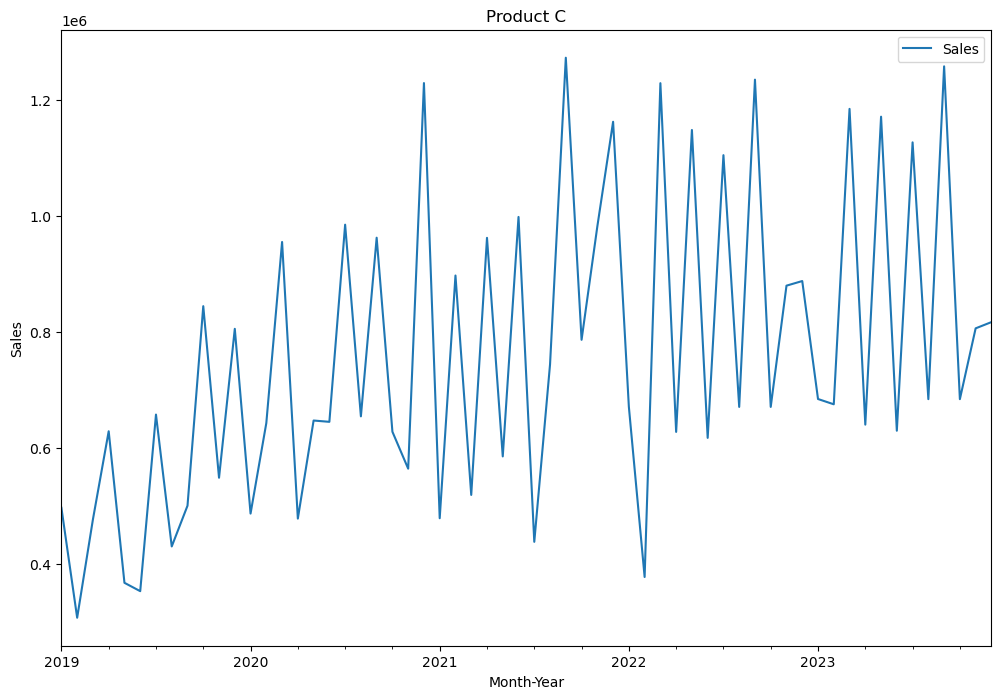

In [5]:
ax = sales_c.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product C')
plt.legend(['Sales'])
plt.show()

In [6]:
train= sales_c[:48]
test=sales_c[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:28 - cmdstanpy - INFO - Chain [1] done processing
22:00:31 - cmdstanpy - INFO - Chain [1] start processing
22:00:31 - cmdstanpy - INFO - Chain [1] done processing
22:00:36 - cmdstanpy - INFO - Chain [1] start processing
22:00:37 - cmdstanpy - INFO - Chain [1] done processing
22:00:41 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing
22:01:02 - cmdstanpy - INFO - Chain [1] start processing
22:01:04 - cmdstanpy - INFO - Chain [1] done processing
22:01:07 - cmdstanpy - INFO - Chain [1] start processing
22:01:07 - cmdstanpy - INFO - Chain [1] done processing
22:01:10 - cmdstanpy - INFO - Chain [1] start processing
22:01:12 - cmdstanpy - INFO - Chain [1] done processing
22:01:14 - cmdstanpy - INFO - Chain [1] start processing
22:01:15 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   150255.740872  
1   100169.091240  
2   128833.666501  
3   123014.773814  
4   119734.787488  
.. 

In [9]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
1,0.001,0.01,multiplicative,100169.091240
4,0.001,1.00,additive,119734.787488
8,0.001,5.00,additive,120113.765271
16,0.010,1.00,additive,120486.118553
22,0.010,10.00,additive,120575.022432
...,...,...,...,...
14,0.010,0.10,additive,127036.610696
38,0.200,0.10,additive,127092.536593
2,0.001,0.10,additive,128833.666501
12,0.010,0.01,additive,129170.362756


In [10]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [26]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01, seasonality_mode='multiplicative',interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [27]:
model.fit(train)

22:06:53 - cmdstanpy - INFO - Chain [1] start processing
22:06:53 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [29]:
future_dates['Market Size'] = sales_c['Market Size']
future_dates['Marketing Expense'] = sales_c['Marketing Expense']

In [30]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,1002744,1578266
1,2019-02-01,619142,974480
2,2019-03-01,962208,1514466
3,2019-04-01,1269687,1998416
4,2019-05-01,740950,1166209
5,2019-06-01,711811,1120336
6,2019-07-01,1327952,2090113
7,2019-08-01,867822,1365910
8,2019-09-01,1009971,1589625
9,2019-10-01,1107516,1743167


In [31]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [32]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [33]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,7.747132e+05,4.924982e+05,1.037264e+06
49,2023-02-01,7.682199e+05,5.023902e+05,1.058679e+06
50,2023-03-01,1.213523e+06,9.315029e+05,1.499941e+06
51,2023-04-01,7.442602e+05,4.772810e+05,1.025402e+06
52,2023-05-01,1.201258e+06,9.230900e+05,1.456199e+06
53,2023-06-01,7.360372e+05,4.619303e+05,1.005658e+06
54,2023-07-01,1.170057e+06,8.820270e+05,1.447202e+06
55,2023-08-01,7.836750e+05,4.904059e+05,1.050687e+06
56,2023-09-01,1.289327e+06,1.038399e+06,1.570642e+06
57,2023-10-01,8.906663e+05,6.195022e+05,1.173878e+06


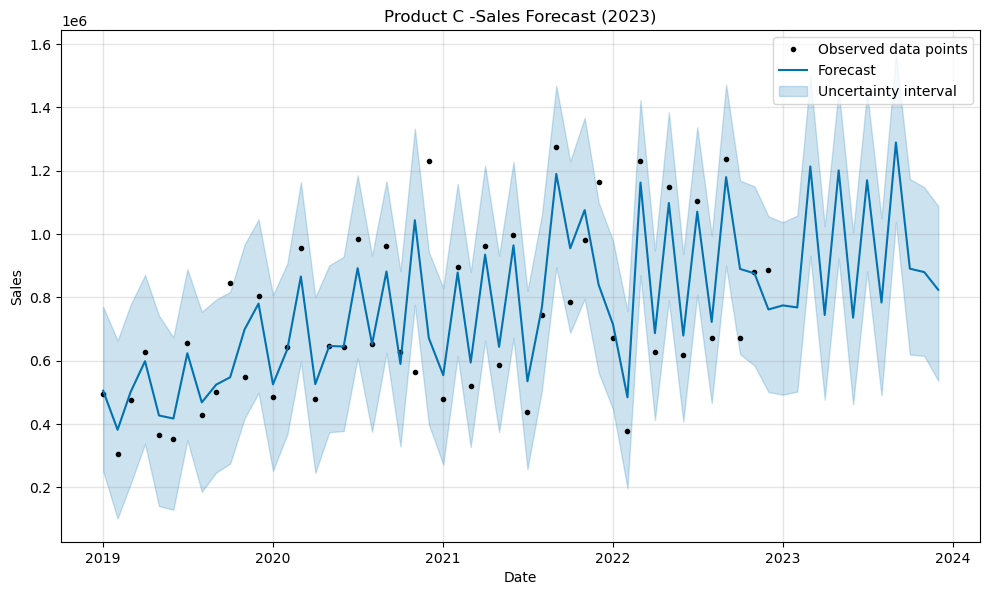

In [34]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product C -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

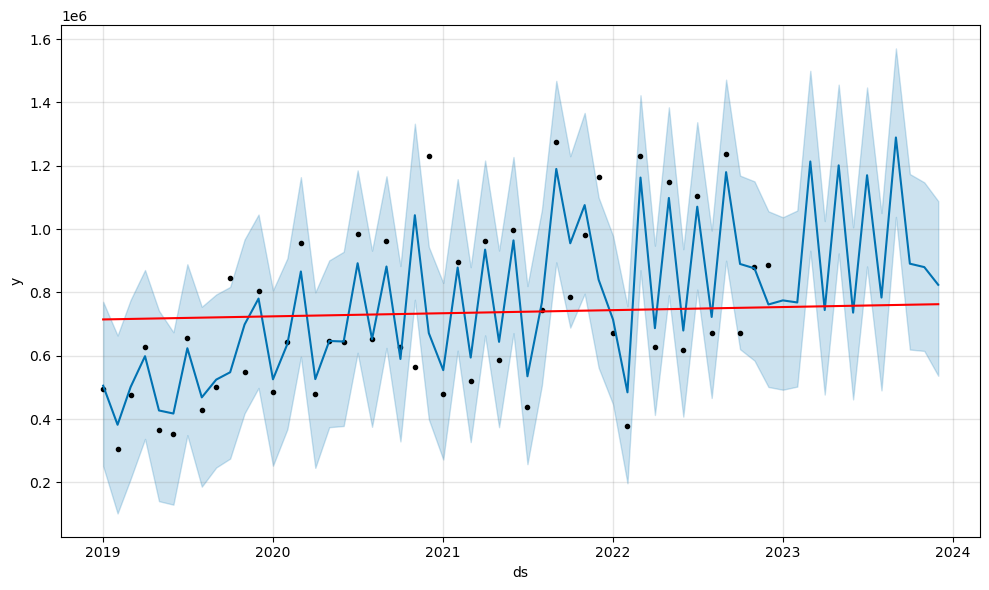

In [35]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

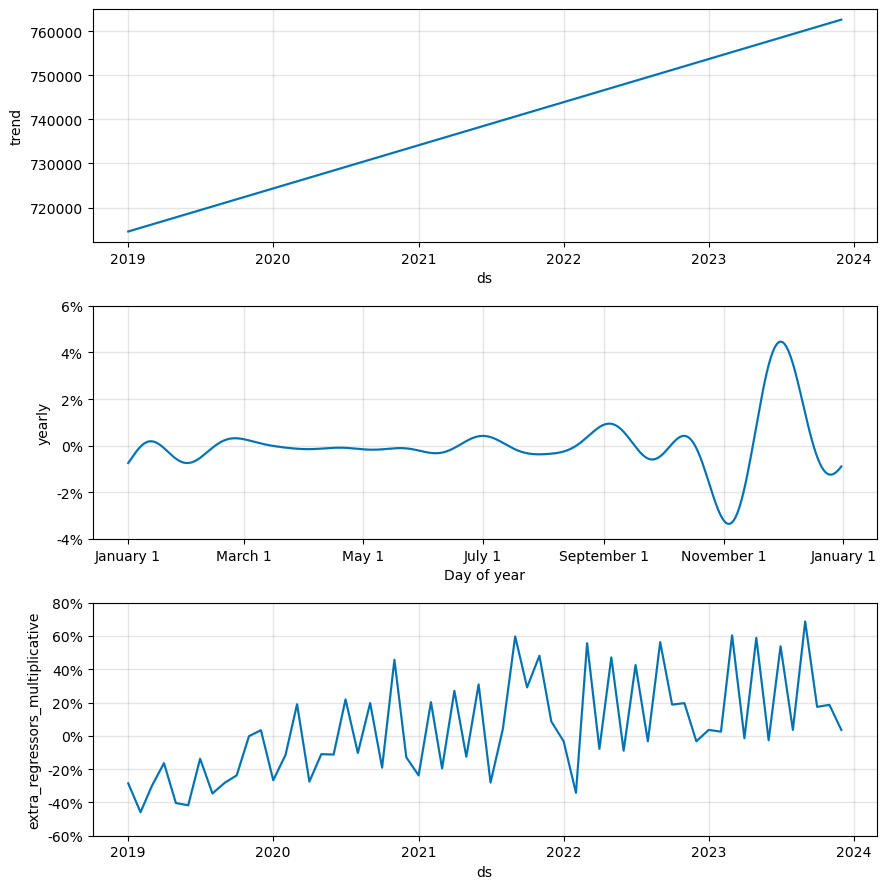

In [36]:
fig2 = model.plot_components(forecast)

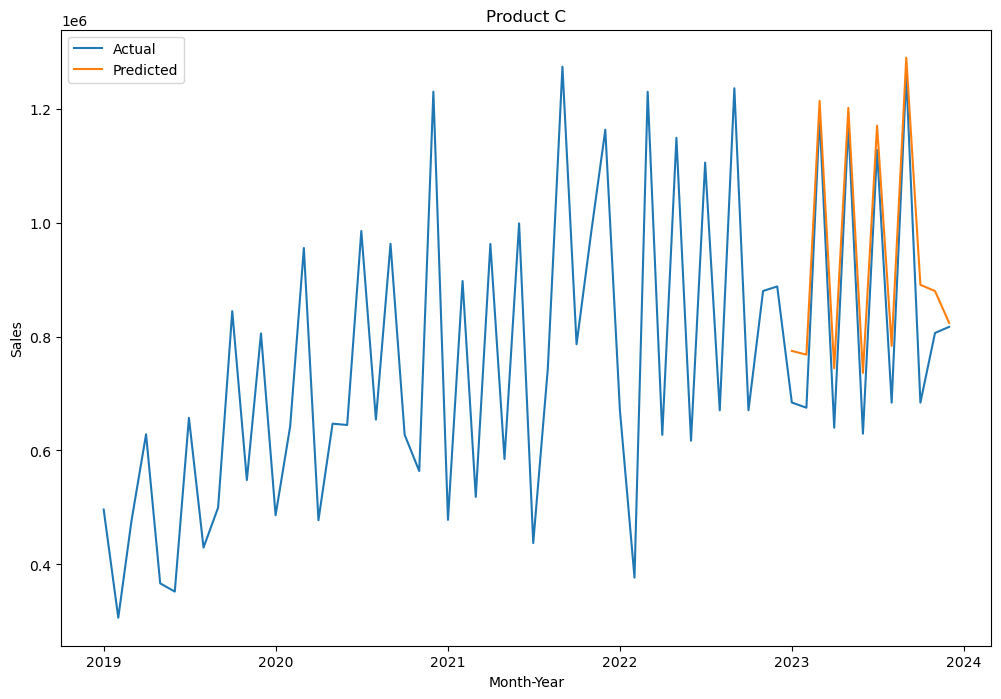

In [37]:
# Reset index of sales_b DataFrame
sales_c_reset_index = sales_c.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_c_reset_index['ds'], sales_c_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product C')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [38]:
#model evaluation

In [39]:
pred=forecasted_df['yhat']
test_df=test['y']

In [40]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 76062.083
MAPE - FB PROPHET: 0.105
MSE - FB PROPHET: 8476823146.759
RMSE - FB PROPHET: 92069.665


In [41]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [42]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,3.381757e+09,58152.880385,58152.880385,0.086697,0.086697,0.083095,1.0
1,62 days,1.730615e+10,131552.852778,131552.852778,0.349140,0.349140,0.297249,1.0
2,90 days,5.848146e+09,76473.173937,76473.173937,0.062192,0.062192,0.064188,1.0
3,121 days,5.249676e+09,72454.646968,72454.646968,0.115489,0.115489,0.109184,1.0
4,151 days,3.379413e+09,58132.716415,58132.716415,0.050604,0.050604,0.051917,1.0
5,182 days,5.482658e+09,74044.975632,74044.975632,0.119997,0.119997,0.113205,1.0
6,212 days,2.047650e+09,45250.964567,45250.964567,0.040940,0.040940,0.041795,1.0
7,243 days,3.584863e+09,59873.725058,59873.725058,0.089294,0.089294,0.085478,1.0
8,274 days,5.815073e+09,76256.623295,76256.623295,0.061709,0.061709,0.063674,1.0
9,304 days,4.892710e+10,221194.719820,221194.719820,0.329883,0.329883,0.283176,1.0


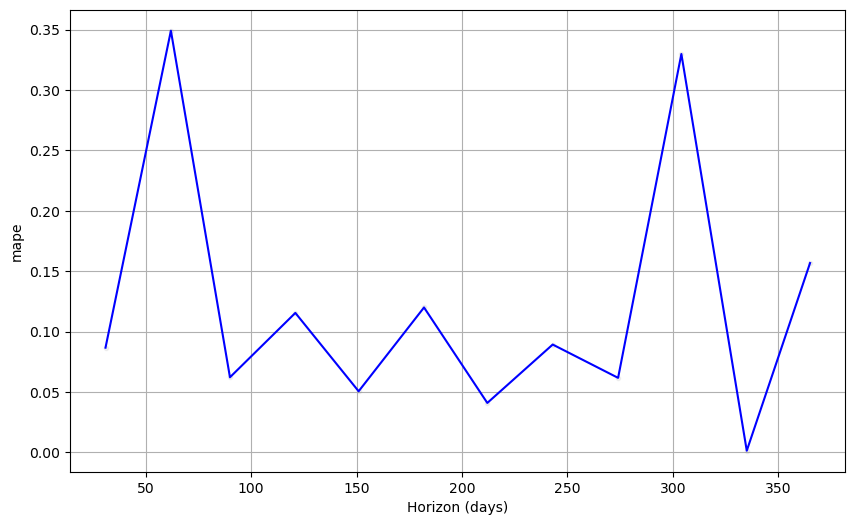

In [43]:
fig = plot_cross_validation_metric(df_cv, metric='mape')